In [252]:
import re
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import solve_ivp, odeint
import math
import pandas as pd
from io import StringIO
from scipy.interpolate import interp1d
import torch
import tensorflow as tf

# Initial Conditions
T0 = 100000
I0 = 0
L0 = 0
V0 = 200

# Parameters
d = 0.01
beta = 0.00000002
f = 0.001
a = 0.2
delta_I = 1 
delta_L = 0.0039
c = 23
p = 4000
lambda_param = 1000  # T0 * d
Omega = 1
epsilon = 0


t_initial = 0
t_final = 450

t = np.linspace(t_initial, t_final, 1000)



geom = dde.geometry.TimeDomain(t_initial, t_final)

Y0 = [T0, I0, L0, V0]

def system(Y, t):
    T, I, L, V = Y
    current_epsilon = 0.9 if t > 100 else 0  # Set epsilon to 0.9 after 100 days
    dT_dt = lambda_param - d * T - Omega * (1 - current_epsilon) * beta * V * T
    dI_dt = (1 - f) * Omega * (1 - current_epsilon) * beta * V * T + a * L - delta_I * I
    dL_dt = f * Omega * (1 - current_epsilon) * beta * V * T - a * L - delta_L * L
    dV_dt = Omega * p * I - c * V
    return [dT_dt, dI_dt, dL_dt, dV_dt]

t = np.linspace(t_initial, t_final, 1000)

solution = odeint(system, Y0, t)
T, I, L, V = solution.T

In [234]:
interp_T = interp1d(t, T, kind='cubic', fill_value='extrapolate')
interp_I = interp1d(t, I, kind='cubic', fill_value='extrapolate')
interp_L = interp1d(t, L, kind='cubic', fill_value='extrapolate')
interp_V = interp1d(t, V, kind='cubic', fill_value='extrapolate')

# Corrected Function to Ensure Proper Shape
def func(t):
    T_val = interp_T(t)
    I_val = interp_I(t)
    L_val = interp_L(t)
    V_val = interp_V(t)
    return np.hstack((T_val, I_val, L_val, V_val))

In [235]:
def ode(t, Y):
    T, I, L, V = Y[:, 0:1], Y[:, 1:2], Y[:, 2:3], Y[:, 3:4]
    
    dT_dt = dde.grad.jacobian(Y, t, i=0)
    dI_dt = dde.grad.jacobian(Y, t, i=1)
    dL_dt = dde.grad.jacobian(Y, t, i=2)
    dV_dt = dde.grad.jacobian(Y, t, i=3)
    
    current_epsilon = tf.where(t > 100, 0.9, 0.0)  # Set epsilon to 0.9 after 100 days
    
    return [
        dT_dt - (lambda_param - d * T - Omega * (1 - current_epsilon) * beta * V * T),
        dI_dt - ((1 - f) * Omega * (1 - current_epsilon) * beta * V * T + a * L - delta_I * I),
        dL_dt - (f * Omega * (1 - current_epsilon) * beta * V * T - a * L - delta_L * L),
        dV_dt - (Omega * p * I - c * V)
    ]
    
def boundary(_, on_initial):
    return on_initial    

ic_T = dde.icbc.IC(geom, lambda x: T0, boundary, component=0)
ic_I = dde.icbc.IC(geom, lambda x: I0, boundary, component=1)
ic_L = dde.icbc.IC(geom, lambda x: L0, boundary, component=2)
ic_V = dde.icbc.IC(geom, lambda x: V0, boundary, component=3)



In [133]:
data = dde.data.PDE(geom, ode, [ic_T, ic_I, ic_L, ic_V], 5000, 4, num_test = 1000)

In [134]:
layer_size = [1] + [64] * 3 + [4]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

In [135]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=10000)

Compiling model...
'compile' took 0.000251 s

Training model...



RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

Saving loss history to c:\Users\sebas\OneDrive\Desktop\Research\loss.dat ...
Saving training data to c:\Users\sebas\OneDrive\Desktop\Research\train.dat ...
Saving test data to c:\Users\sebas\OneDrive\Desktop\Research\test.dat ...


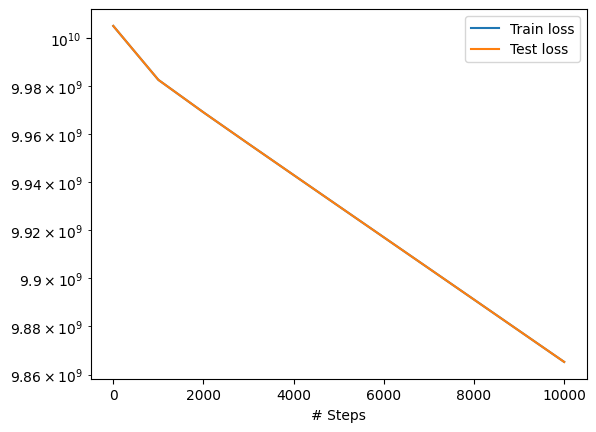

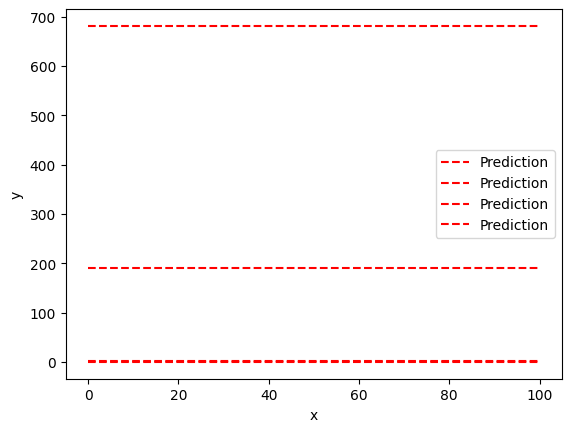

In [107]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


C:\Users\sebas\AppData\Local\Temp\ipykernel_7376\3931973995.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(t, np.log10(V), color="blue", label="log10 V (ODEint)", linestyle='--')


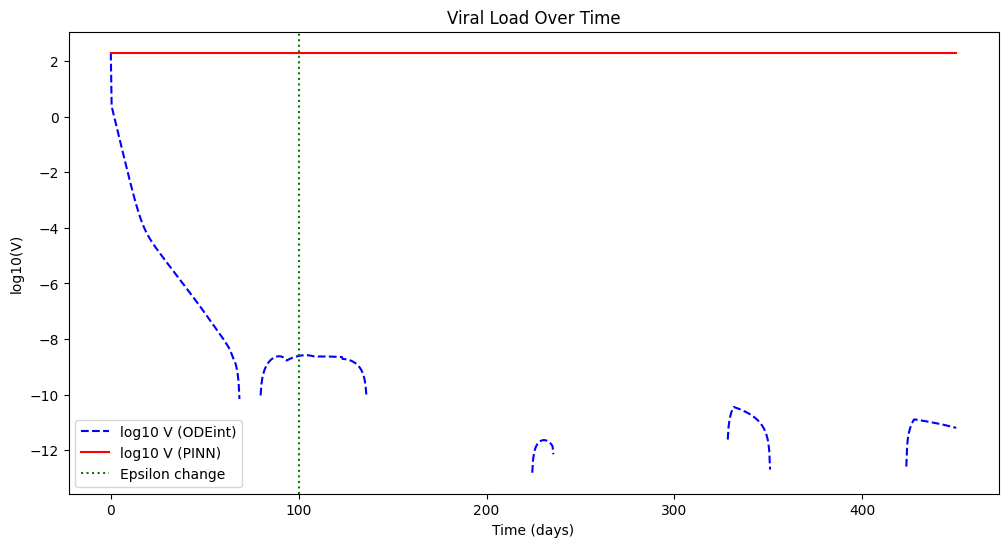

In [129]:
plt.figure(figsize=(12, 6))
plt.plot(t, np.log10(V), color="blue", label="log10 V (ODEint)", linestyle='--')
plt.plot(t, np.log10(V_pinn), color="red", label="log10 V (PINN)", linestyle='-')
plt.axvline(x=100, color='green', linestyle=':', label='Epsilon change')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('log10(V)')
plt.title('Viral Load Over Time')
plt.show()

C:\Users\sebas\AppData\Local\Temp\ipykernel_7376\3075007363.py:44: RuntimeWarning: invalid value encountered in log10
  plt.plot(t, np.log10(V))


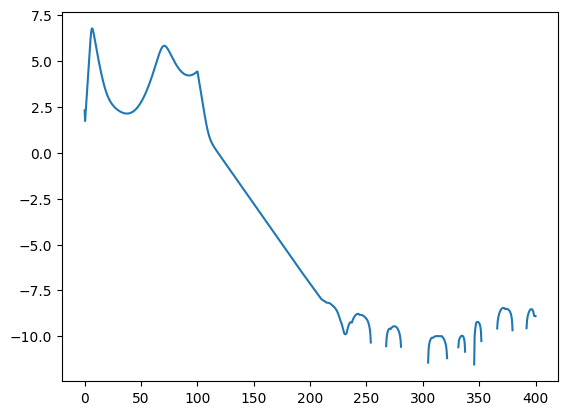

In [262]:
# Initial Conditions
T0 = 100000
I0 = 0
L0 = 0
V0 = 200

# Parameters
d = 0.01
beta = 2e-7
f = 0.001
a = 0.2
delta_I = 1 
delta_L = 0.0039
c = 23
p = 4000
lambda_param = 1000  # T0 * d
Omega = 1

t_initial = 0
t_final = 400

t = np.linspace(t_initial, t_final, 1000)

#current_epsilon = 0

geom = dde.geometry.TimeDomain(t_initial, t_final)

Y0 = [T0, I0, L0, V0]

def system(Y, t):
    T, I, L, V = Y
    current_epsilon = 0.9 if t > 100 else 0  # Set epsilon to 0.9 after 100 days
    dT_dt = lambda_param - d * T - Omega * (1 - current_epsilon) * beta * V * T
    dI_dt = (1 - f) * Omega * (1 - current_epsilon) * beta * V * T + a * L - delta_I * I
    dL_dt = f * Omega * (1 - current_epsilon) * beta * V * T - a * L - delta_L * L
    dV_dt = Omega * p * I - c * V
    return [dT_dt, dI_dt, dL_dt, dV_dt]

t = np.linspace(t_initial, t_final, 1000)

solution = odeint(system, Y0, t)
T, I, L, V = solution.T

plt.plot(t, np.log10(V))
plt.show()


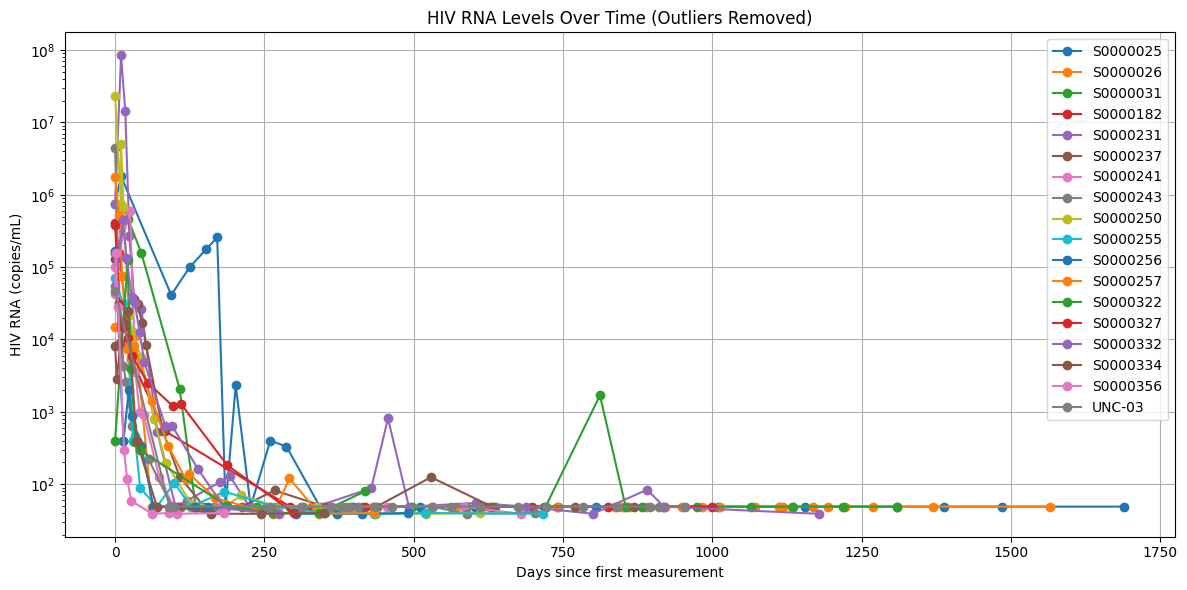

Average drug start time: 58.23 days


In [327]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import deepxde as dde

# Read the data from the CSV file
df = pd.read_csv('Vdata.csv')

# Convert 'labdt' to datetime using 'mixed' format
df['labdt'] = pd.to_datetime(df['labdt'], format='mixed', errors='coerce')

# Remove rows where hivrna is empty or labdt is invalid
df = df.dropna(subset=['hivrna', 'labdt'])

# Convert hivrna to numeric, replacing any non-numeric values with NaN
df['hivrna'] = pd.to_numeric(df['hivrna'], errors='coerce')

# Remove outliers
outliers = ['UNC-08', 'S0000019']
df = df[~df['uid'].isin(outliers)]

# Load the HIV data
hiv_data = pd.read_csv('HIVdata.csv')

# Convert dates to datetime using 'mixed' format
hiv_data['medDT'] = pd.to_datetime(hiv_data['medDT'], format='mixed', errors='coerce')
hiv_data['EstInfDT'] = pd.to_datetime(hiv_data['EstInfDT'], format='mixed', errors='coerce')

# Remove rows with invalid dates
hiv_data = hiv_data.dropna(subset=['medDT', 'EstInfDT'])

# Remove outliers from hiv_data as well
hiv_data = hiv_data[~hiv_data['uid'].isin(outliers)]

# Calculate the drug start time (in days since infection) for each patient
hiv_data['drug_start_time'] = (hiv_data['medDT'] - hiv_data['EstInfDT']).dt.total_seconds() / (24 * 3600)

# Calculate the average drug start time
avg_drug_start_time = hiv_data['drug_start_time'].mean()

# Extract relevant information
days_meds_to_iupb = hiv_data['DaysMEDStoIUPB'].dropna().values
infected_cells_per_billion = hiv_data['Infected cells per Billion'].dropna().values

# Normalize the time and infected cell data
max_time = np.max(days_meds_to_iupb)
max_infected = np.max(infected_cells_per_billion)
days_meds_to_iupb_norm = days_meds_to_iupb / max_time
infected_cells_per_billion_norm = infected_cells_per_billion / max_infected

# Create the plot
plt.figure(figsize=(12, 6))

# Plot data for each unique uid
for uid in df['uid'].unique():
    data = df[df['uid'] == uid].sort_values('labdt')
    
    # Calculate days since first measurement for this patient
    data['days_since_start'] = (data['labdt'] - data['labdt'].min()).dt.days
    
    plt.semilogy(data['days_since_start'], data['hivrna'], 'o-', label=uid)

plt.xlabel('Days since first measurement')
plt.ylabel('HIV RNA (copies/mL)')
plt.title('HIV RNA Levels Over Time (Outliers Removed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print average drug start time
print(f"Average drug start time: {avg_drug_start_time:.2f} days")

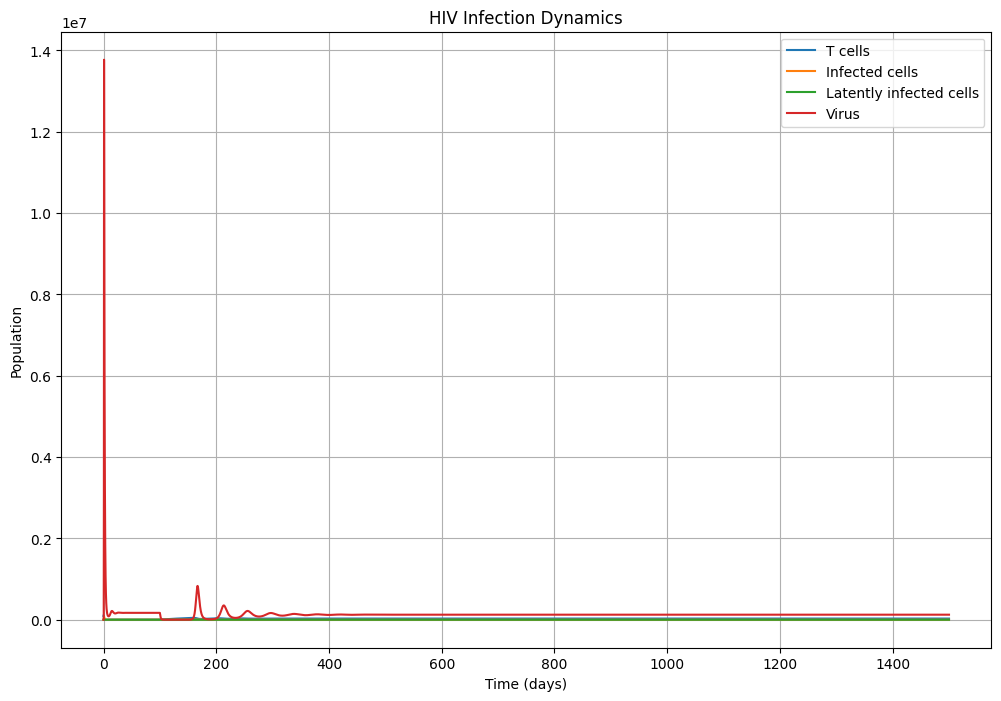

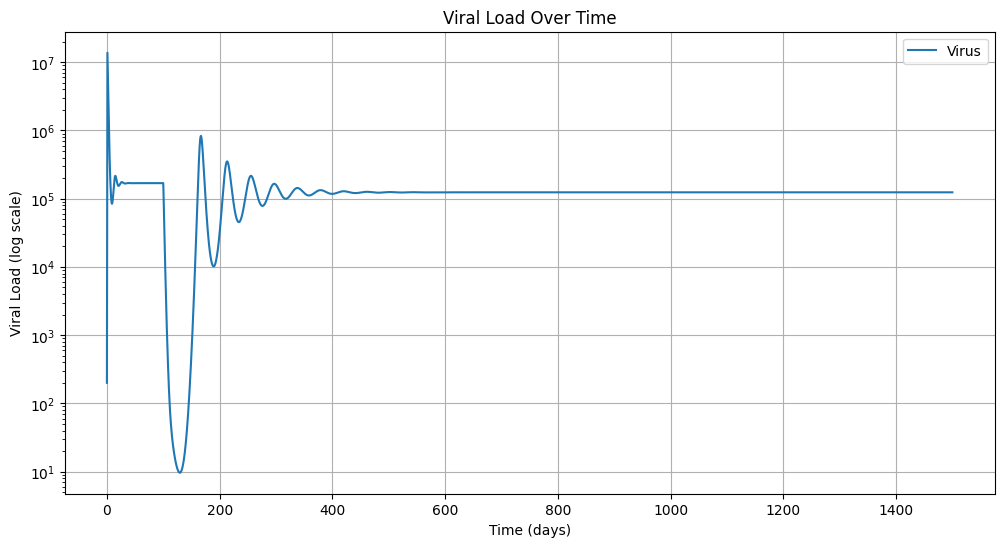

Final T: 28750.55
Final I: 712.48
Final L: 3.49
Final V: 123909.72


In [328]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parameters
d = 0.01
beta = 2e-6
f = 0.001
a = 0.2
delta_I = 1 
delta_L = 0.0039
c = 23
p = 4000
lambda_param = 1000
Omega = 1

# Initial conditions
T0 = 100000
I0 = 0
L0 = 0
V0 = 200

# Time points
t_initial = 0
t_final = 1500
t = np.linspace(t_initial, t_final, 5000)

# Define the system of equations
def system(y, t):
    T, I, L, V = y
    epsilon = 0.9 if t > 100 else 0  # Set epsilon to 0.9 after 100 days
    
    dT_dt = lambda_param - d * T - Omega * (1 - epsilon) * beta * V * T
    dI_dt = (1 - f) * Omega * (1 - epsilon) * beta * V * T + a * L - delta_I * I
    dL_dt = f * Omega * (1 - epsilon) * beta * V * T - a * L - delta_L * L
    dV_dt = Omega * p * I - c * V
    
    return [dT_dt, dI_dt, dL_dt, dV_dt]

# Initial conditions vector
y0 = [T0, I0, L0, V0]

# Solve the ODE system
solution = odeint(system, y0, t)

# Extract the solutions
T, I, L, V = solution.T

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(t, T, label='T cells')
plt.plot(t, I, label='Infected cells')
plt.plot(t, L, label='Latently infected cells')
plt.plot(t, V, label='Virus')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('HIV Infection Dynamics')
plt.legend()
plt.grid(True)

# Plot V on a logarithmic scale
plt.figure(figsize=(12, 6))
plt.semilogy(t, V, label='Virus')
plt.xlabel('Time (days)')
plt.ylabel('Viral Load (log scale)')
plt.title('Viral Load Over Time')
plt.legend()
plt.grid(True)

plt.show()

# Print final values
print(f"Final T: {T[-1]:.2f}")
print(f"Final I: {I[-1]:.2f}")
print(f"Final L: {L[-1]:.2f}")
print(f"Final V: {V[-1]:.2f}")

In [336]:
import re
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import solve_ivp, odeint
import math
import pandas as pd
from io import StringIO
from scipy.interpolate import interp1d
import torch
import tensorflow as tf

# Initial Conditions
T0 = 100000
I0 = 0
L0 = 0
V0 = 200

# Parameters
d = 0.01
beta = 2e-6
f = 0.001
a = 0.2
delta_I = 1 
delta_L = 0.0039
c = 23
p = 4000
lambda_param = 1000  # T0 * d
Omega = 1

t_initial = 0
t_final = 1500

t = np.linspace(t_initial, t_final, 5000)

# Normalize the data
T_max, I_max, L_max, V_max = np.max(solution, axis=0)
solution_normalized = solution / np.array([T_max, I_max, L_max, V_max])
T_ode, I_ode, L_ode, V_ode = solution_normalized.T

# Update the initial conditions
T0_norm, I0_norm, L0_norm, V0_norm = solution_normalized[0]

# PINN setup
geom = dde.geometry.TimeDomain(t_initial, t_final)

def HIV_system(t, y):
    T, I, L, V = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]
    dT_dt = dde.grad.jacobian(y, t, i=0)
    dI_dt = dde.grad.jacobian(y, t, i=1)
    dL_dt = dde.grad.jacobian(y, t, i=2)
    dV_dt = dde.grad.jacobian(y, t, i=3)
    
    # Use the average drug start time to set epsilon
    epsilon = torch.where(t > avg_drug_start_time, torch.tensor(0.9), torch.tensor(0.0))
    
    return [
        dT_dt - (lambda_param/T_max - d * T - (1 - epsilon) * beta * V_max * T * V),
        dI_dt - ((1 - f) * (1 - epsilon) * beta * T_max * V_max * T * V / I_max + a * L_max * L / I_max - delta_I * I),
        dL_dt - (f * (1 - epsilon) * beta * T_max * V_max * T * V / L_max - a * L - delta_L * L),
        dV_dt - (p * I_max * I / V_max - c * V)
    ]

# Define initial conditions
def boundary(_, on_initial):
    return on_initial

ic_T = dde.icbc.IC(geom, lambda X: T0_norm, boundary, component=0)
ic_I = dde.icbc.IC(geom, lambda X: I0_norm, boundary, component=1)
ic_L = dde.icbc.IC(geom, lambda X: L0_norm, boundary, component=2)
ic_V = dde.icbc.IC(geom, lambda X: V0_norm, boundary, component=3)

# Prepare observation data
observe_t = t.reshape(-1, 1)
observe_V = V_ode.reshape(-1, 1)
observe_V = dde.icbc.PointSetBC(observe_t, observe_V, component=3)

# Define the PDE problem with adjusted weights
data = dde.data.PDE(
    geom,
    HIV_system,
    [ic_T, ic_I, ic_L, ic_V, observe_V],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
    solution=lambda x: solution_normalized[np.searchsorted(t, x)],
    num_test=1000,
)

# Define variables to be learned
d = dde.Variable(0.01)
beta = dde.Variable(2e-8)
f = dde.Variable(0.001)
a = dde.Variable(0.2)
delta_I = dde.Variable(1.0)
#delta_L = dde.Variable(0.0039)
c = dde.Variable(23.0)
p = dde.Variable(4000.0)
lambda_param = dde.Variable(1000.0)

external_trainable_variables = [d, beta, f, a, delta_I, c, p, lambda_param]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=1000, filename="variables.dat"
)


# Define a more complex network
net = dde.nn.FNN([1] + [64] * 4 + [4], "tanh", "Glorot uniform")
model = dde.Model(data, net)

# Compile the model with a fixed initial learning rate
initial_lr = 1e-3
model.compile("adam", lr=initial_lr, external_trainable_variables=external_trainable_variables)

# Define a custom learning rate scheduler callback
class LearningRateScheduler(dde.callbacks.Callback):
    def __init__(self, schedule, frequency=1000):
        super().__init__()
        self.schedule = schedule
        self.frequency = frequency

    def on_epoch_end(self):
        if self.model.train_state.epoch % self.frequency == 0:
            lr = self.schedule(self.model.train_state.epoch)
            self.model.compile("adam", lr=lr, external_trainable_variables=external_trainable_variables)

# Define the learning rate schedule
def lr_schedule(epoch):
    if epoch < 5000:
        return initial_lr
    elif epoch < 10000:
        return initial_lr * 0.1
    else:
        return initial_lr * 0.01

# Create the custom callback
lr_callback = LearningRateScheduler(lr_schedule, frequency=1000)

# Train the model with the learning rate scheduler
losshistory, train_state = model.train(iterations=25000, callbacks=[variable, lr_callback])

Compiling model...
'compile' took 0.000434 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.25e-04, 8.42e-01, 1.16e-02, 9.63e+02, 1.00e+00, 0.00e+00, 0.00e+00, 2.11e-10, 2.20e-01]    [1.20e-04, 8.43e-01, 1.16e-02, 9.64e+02, 1.00e+00, 0.00e+00, 0.00e+00, 2.11e-10, 2.20e-01]    []  


1000      [5.20e-04, 5.96e-04, 4.45e-04, 2.57e-02, 1.10e+00, 2.03e-05, 6.06e-08, 1.72e-03, 1.73e-03]    [4.57e-04, 5.94e-04, 4.39e-04, 2.53e-02, 1.10e+00, 2.03e-05, 6.06e-08, 1.72e-03, 1.73e-03]    []  
Compiling model...
'compile' took 0.000740 s

2000      [3.49e-02, 2.63e-01, 8.39e-03, 5.22e-02, 9.20e-01, 1.71e-03, 3.82e-04, 5.64e-03, 4.29e-01]    [3.46e-02, 2.62e-01, 8.21e-03, 5.11e-02, 9.20e-01, 1.71e-03, 3.82e-04, 5.64e-03, 4.29e-01]    []  
Compiling model...
'compile' took 0.000524 s

3000      [1.97e-02, 4.03e-02, 2.64e-02, 2.95e-02, 9.32e-01, 3.36e-05, 5.83e-04, 8.08e-05, 6.96e-04]    [1.95e-02, 4.01e-02, 2.62e-02, 2.95e-02, 9.32e-01, 3.36e-05, 5.83e-04, 8.08e-05, 6.96e-04]    []  
Compiling model...
'compile' took 0.000454 s

4000      [3.79e-04, 6.11e-03, 1.99e-03, 3.72e-03, 8.69e-01, 4.31e-04, 1.30e-04, 3.01e-04, 8.77e-03]    [3.57e-04, 6.12e-03, 1.96e-03, 3.50e-03, 8.69e-01, 4.31e-04, 1.30e-04, 3.01e-04, 8.77e-03]    []  
Compiling model...
'compile' took 0.000726 s

5000

Predicted d: 0.0459755138
Predicted beta: 0.0000003091
Predicted f: 0.0000300367
Predicted a: 0.1169803366
Predicted delta_I: 0.6223979592
Predicted delta_L: -0.1169796437
Predicted c: 22.8677101135
Predicted p: 3999.8542480469
Predicted lambda: 999.7748413086


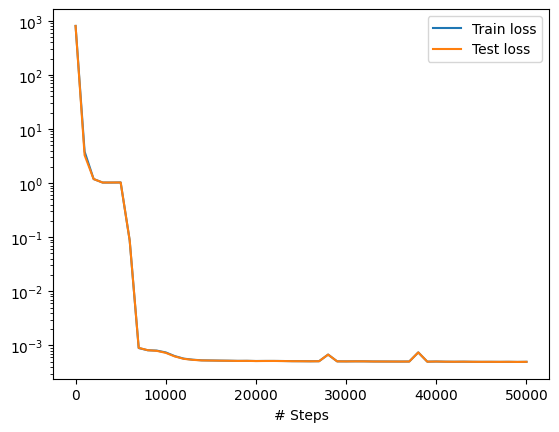

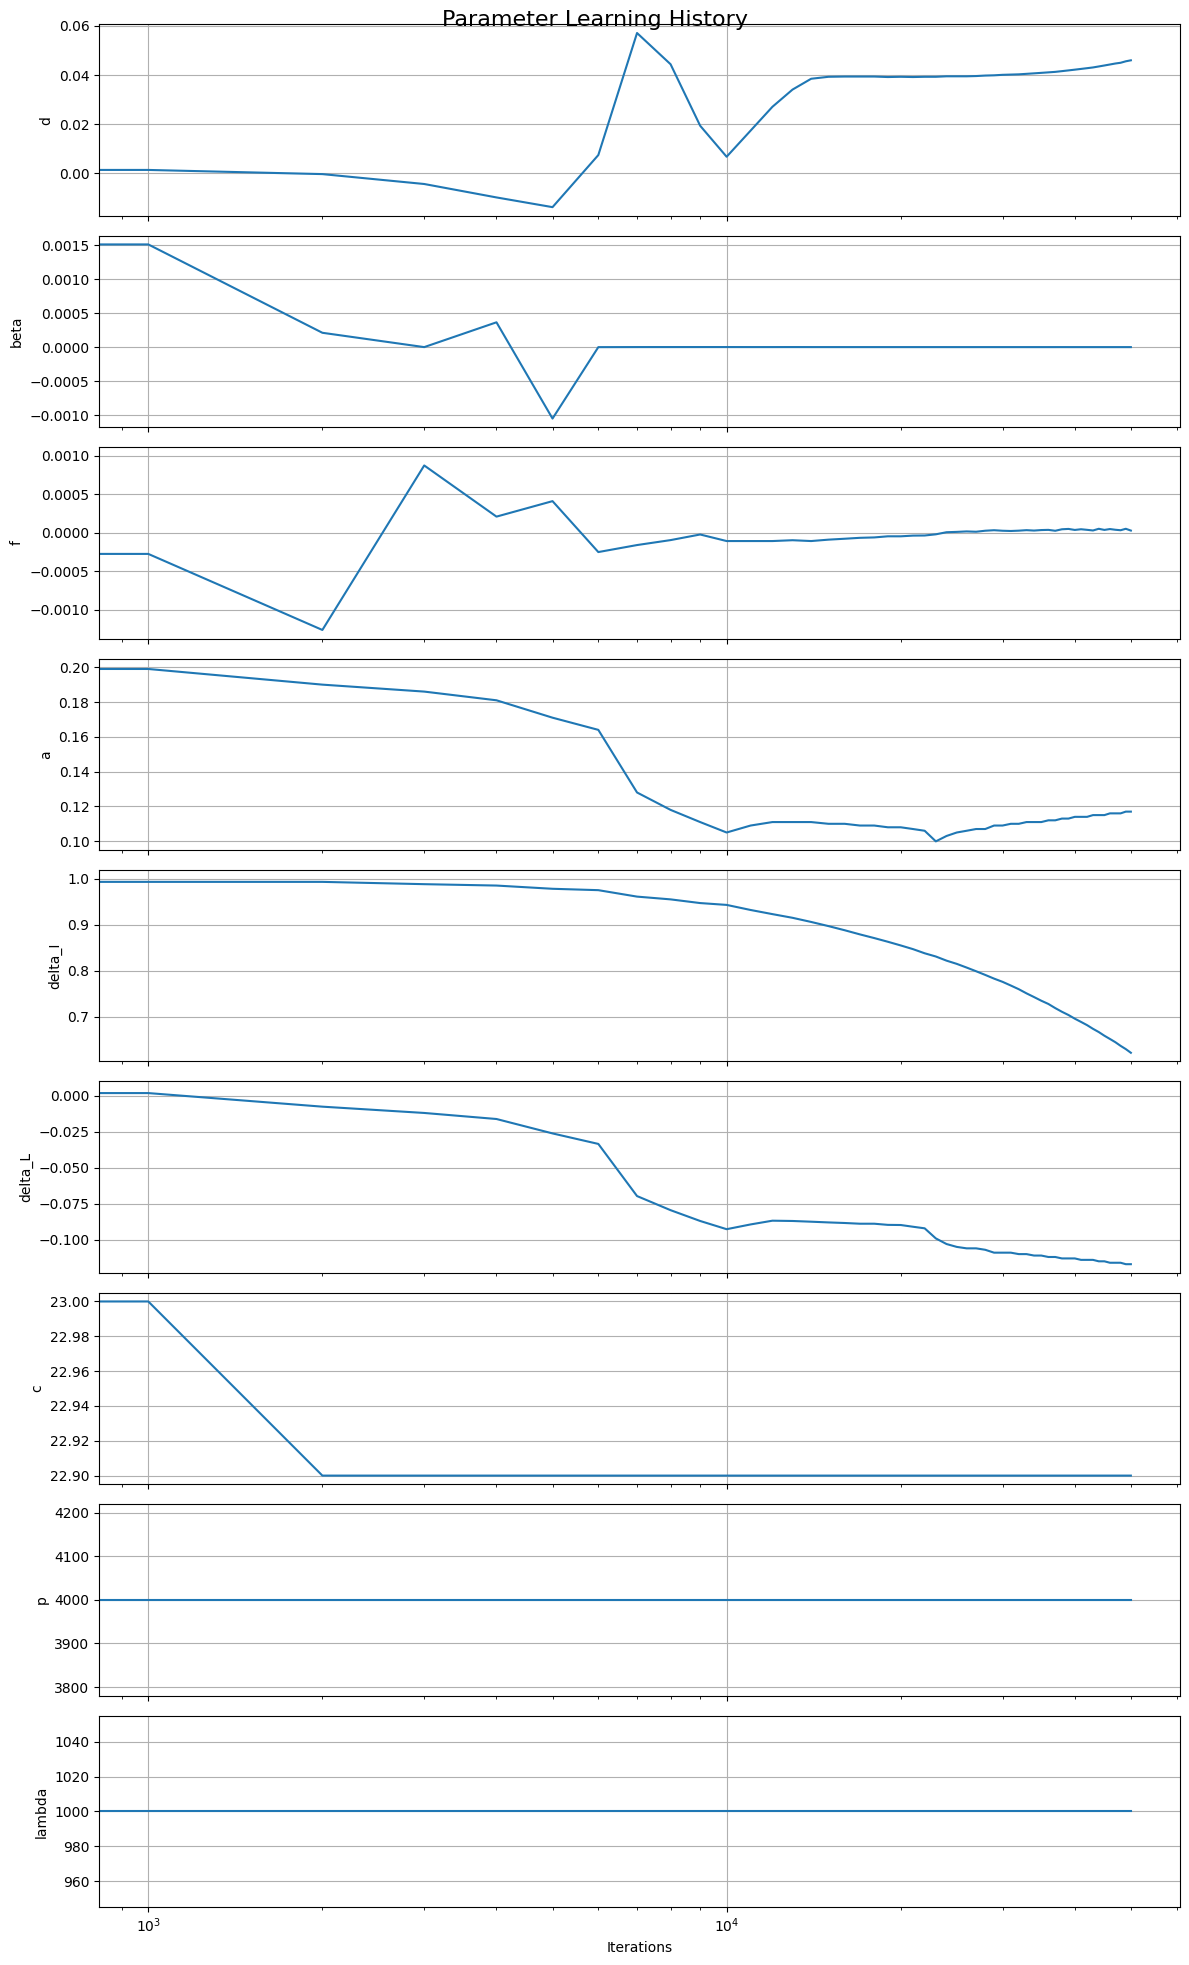

Final learned parameter values:
d: 0.046000
beta: 0.000000
f: 0.000030
a: 0.117000
delta_I: 0.622000
delta_L: -0.117000
c: 22.900000
p: 4000.000000
lambda: 1000.000000


In [331]:
dde.utils.external.plot_loss_history(losshistory)



d_pred, beta_pred, f_pred, a_pred, delta_I_pred, c_pred, p_pred, lambda_pred = variable.value

# Print predicted parameter values
print(f"Predicted d: {d_pred:.10f}")
print(f"Predicted beta: {beta_pred:.10f}")
print(f"Predicted f: {f_pred:.10f}")
print(f"Predicted a: {a_pred:.10f}")
print(f"Predicted delta_I: {delta_I_pred:.10f}")
#print(f"Predicted delta_L: {delta_L_pred:.10f}")
print(f"Predicted c: {c_pred:.10f}")
print(f"Predicted p: {p_pred:.10f}")
print(f"Predicted lambda: {lambda_pred:.10f}")


import numpy as np
import matplotlib.pyplot as plt
import re

# Read the variables.dat file
lines = open("variables.dat", "r").readlines()

# Extract iterations and parameter values
raw_parameters_pred_history = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
iterations = [int(re.findall("^[0-9]+", line)[0]) for line in lines]

# Define parameter names
parameter_names = ['d', 'beta', 'f', 'a', 'delta_I', 'c', 'p', 'lambda']

# Create a dictionary of parameter histories
parameters_pred_history = {
    name: raw_parameters_pred_history[:, i]
    for i, name in enumerate(parameter_names)
}

# Create the plot
n_callbacks, n_variables = raw_parameters_pred_history.shape
fig, axes = plt.subplots(nrows=n_variables, figsize=(12, 20), sharex=True)
fig.suptitle("Parameter Learning History", fontsize=16)

for ax, (parameter, parameter_values) in zip(axes, parameters_pred_history.items()):
    ax.plot(iterations, parameter_values, "-")
    ax.set_ylabel(parameter)
    ax.grid(True)
    ax.set_xscale('log')  # Use log scale for x-axis

axes[-1].set_xlabel("Iterations")
fig.tight_layout()
plt.show()

# Print final learned values
print("Final learned parameter values:")
for name, values in parameters_pred_history.items():
    print(f"{name}: {values[-1]:.6f}")


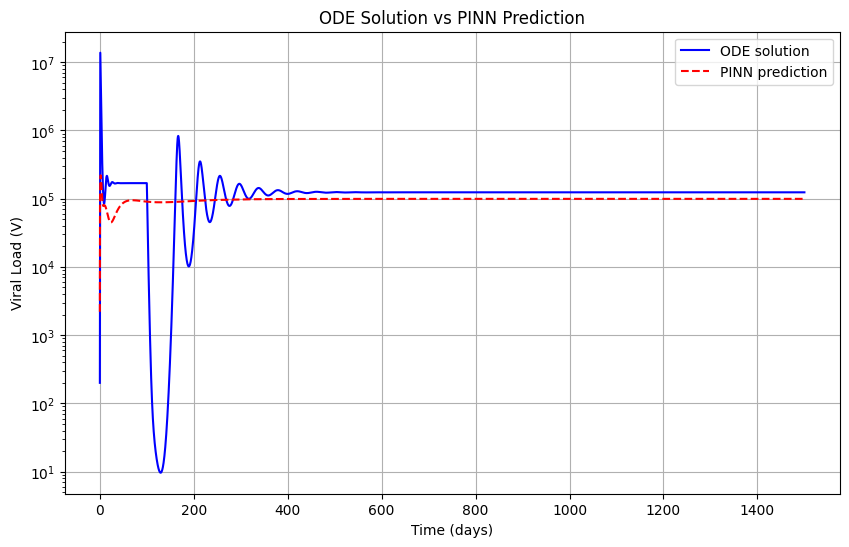

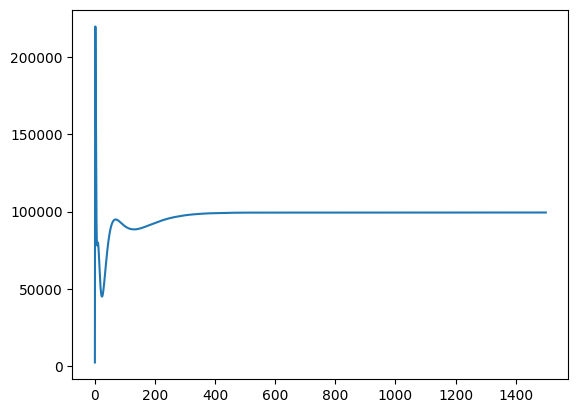

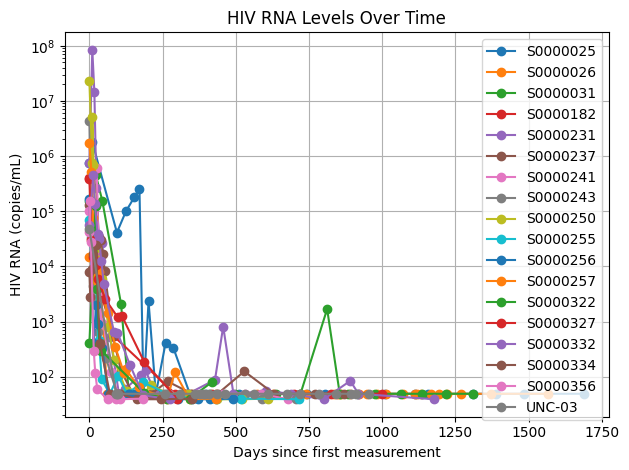

In [332]:
# Get the predicted values
t_pred = np.linspace(0, 1500, 5000).reshape(-1, 1)
y_pred = model.predict(t_pred)
T_pred = y_pred[:, 0]
I_pred = y_pred[:, 1]
L_pred = y_pred[:, 2]
V_pred = y_pred[:, 3]  # V is the 4th component (index 3)


# Denormalize the predictions
y_pred_denorm = y_pred * np.array([T_max, I_max, L_max, V_max])
T_pred_denorm = y_pred_denorm[:, 0]
I_pred_denorm = y_pred_denorm[:, 1]
L_pred_denorm = y_pred_denorm[:, 2]
V_pred_denorm = y_pred_denorm[:, 3]

plt.figure(figsize=(10, 6))
plt.semilogy(t, V, label='ODE solution', color='blue')
plt.semilogy(t_pred, V_pred_denorm, label='PINN prediction', color='red', linestyle='--')
plt.xlabel('Time (days)')
plt.ylabel('Viral Load (V)')
plt.title('ODE Solution vs PINN Prediction')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(t, V_pred_denorm)
plt.show()


for uid in df['uid'].unique():
    data = df[df['uid'] == uid].sort_values('labdt')
    
    # Calculate days since first measurement for this patient
    data['days_since_start'] = (data['labdt'] - data['labdt'].min()).dt.days
    
    plt.semilogy(data['days_since_start'], data['hivrna'], 'o-', label=uid)

plt.xlabel('Days since first measurement')
plt.ylabel('HIV RNA (copies/mL)')
plt.title('HIV RNA Levels Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


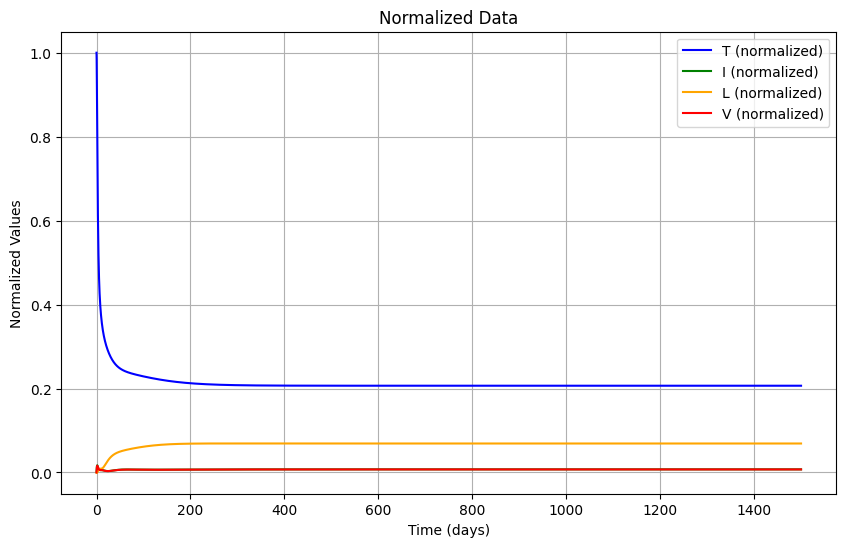

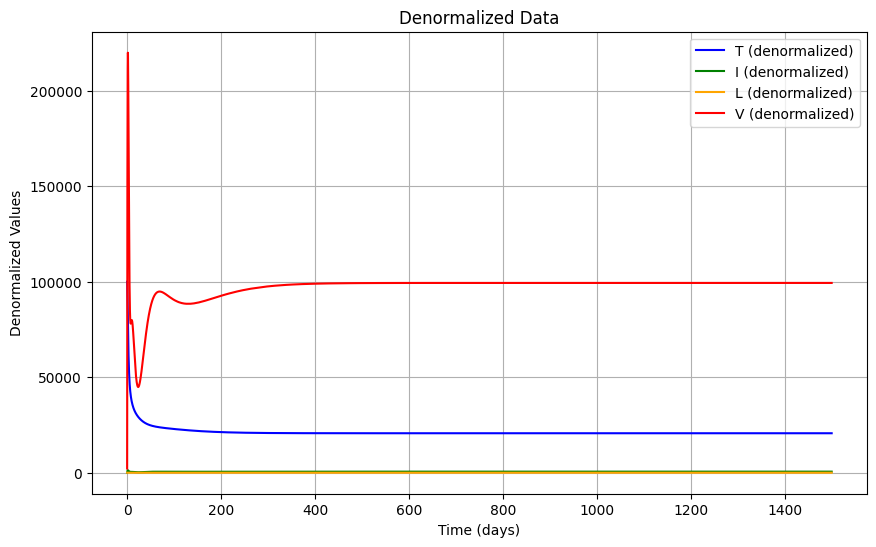

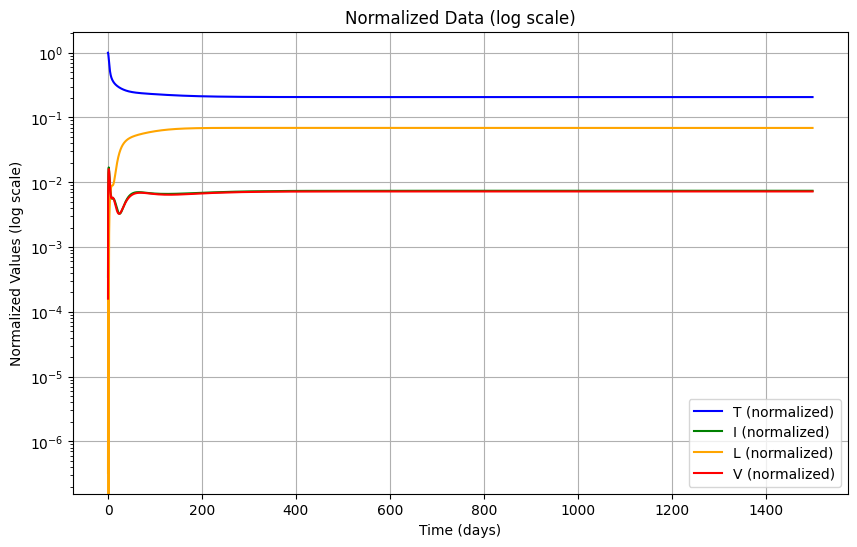

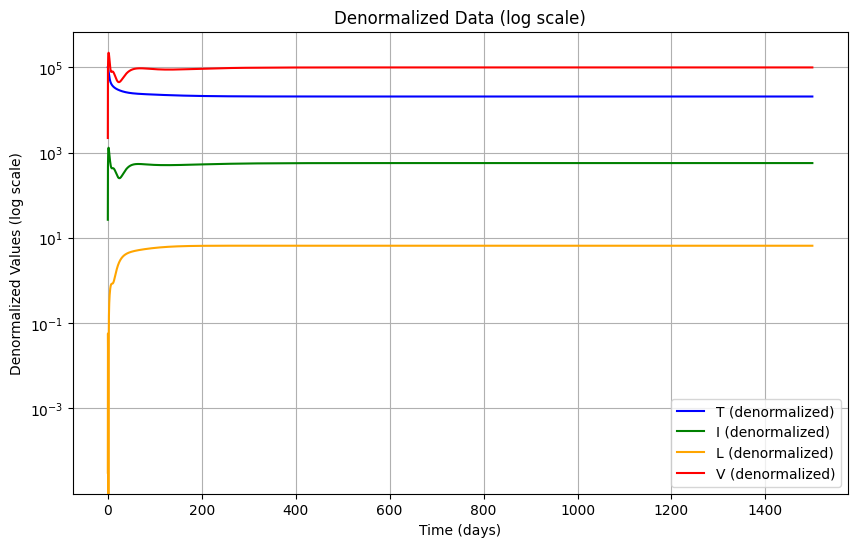

In [333]:
# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(t_pred, T_pred, label='T (normalized)', color='blue')
plt.plot(t_pred, I_pred, label='I (normalized)', color='green')
plt.plot(t_pred, L_pred, label='L (normalized)', color='orange')
plt.plot(t_pred, V_pred, label='V (normalized)', color='red')
plt.xlabel('Time (days)')
plt.ylabel('Normalized Values')
plt.title('Normalized Data')
plt.legend()
plt.grid(True)
plt.show()

# Plot the denormalized data
plt.figure(figsize=(10, 6))
plt.plot(t_pred, T_pred_denorm, label='T (denormalized)', color='blue')
plt.plot(t_pred, I_pred_denorm, label='I (denormalized)', color='green')
plt.plot(t_pred, L_pred_denorm, label='L (denormalized)', color='orange')
plt.plot(t_pred, V_pred_denorm, label='V (denormalized)', color='red')
plt.xlabel('Time (days)')
plt.ylabel('Denormalized Values')
plt.title('Denormalized Data')
plt.legend()
plt.grid(True)
plt.show()

# Plot the normalized data with semilogy
plt.figure(figsize=(10, 6))
plt.semilogy(t_pred, T_pred, label='T (normalized)', color='blue')
plt.semilogy(t_pred, I_pred, label='I (normalized)', color='green')
plt.semilogy(t_pred, L_pred, label='L (normalized)', color='orange')
plt.semilogy(t_pred, V_pred, label='V (normalized)', color='red')
plt.xlabel('Time (days)')
plt.ylabel('Normalized Values (log scale)')
plt.title('Normalized Data (log scale)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the denormalized data with semilogy
plt.figure(figsize=(10, 6))
plt.semilogy(t_pred, T_pred_denorm, label='T (denormalized)', color='blue')
plt.semilogy(t_pred, I_pred_denorm, label='I (denormalized)', color='green')
plt.semilogy(t_pred, L_pred_denorm, label='L (denormalized)', color='orange')
plt.semilogy(t_pred, V_pred_denorm, label='V (denormalized)', color='red')
plt.xlabel('Time (days)')
plt.ylabel('Denormalized Values (log scale)')
plt.title('Denormalized Data (log scale)')
plt.legend()
plt.grid(True)
plt.show()



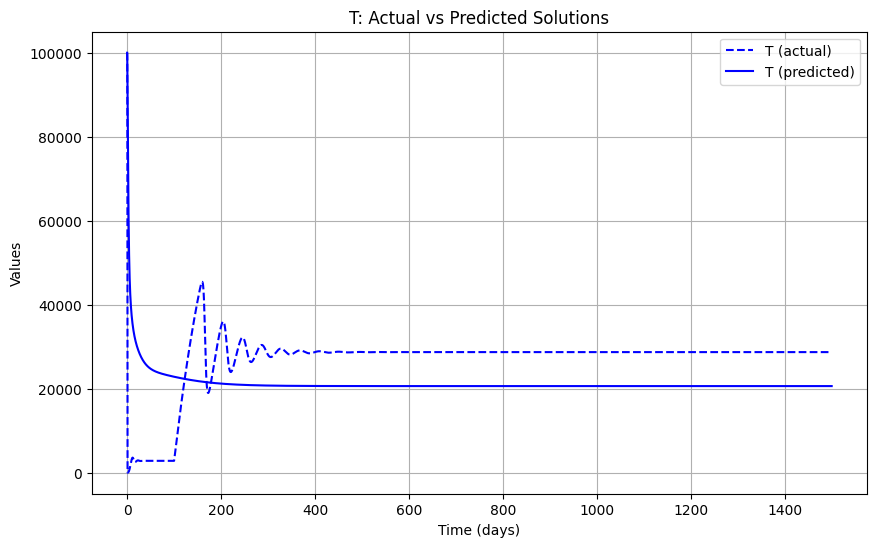

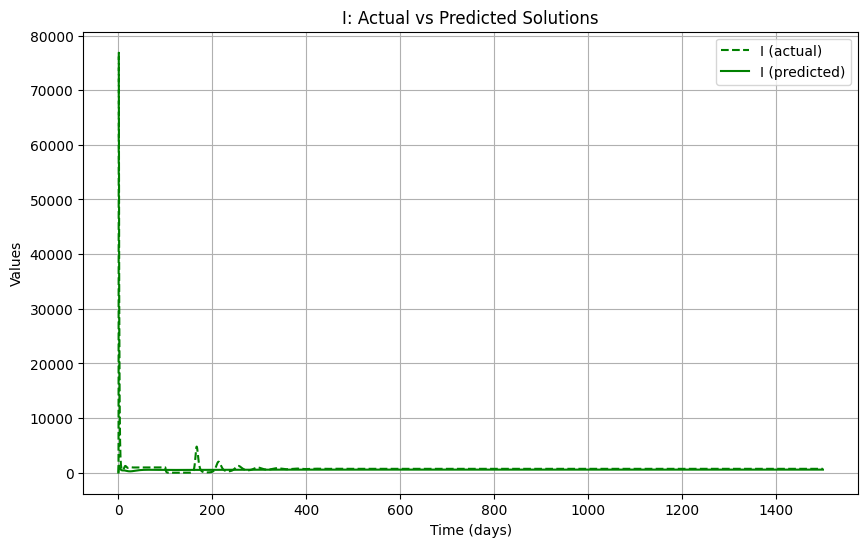

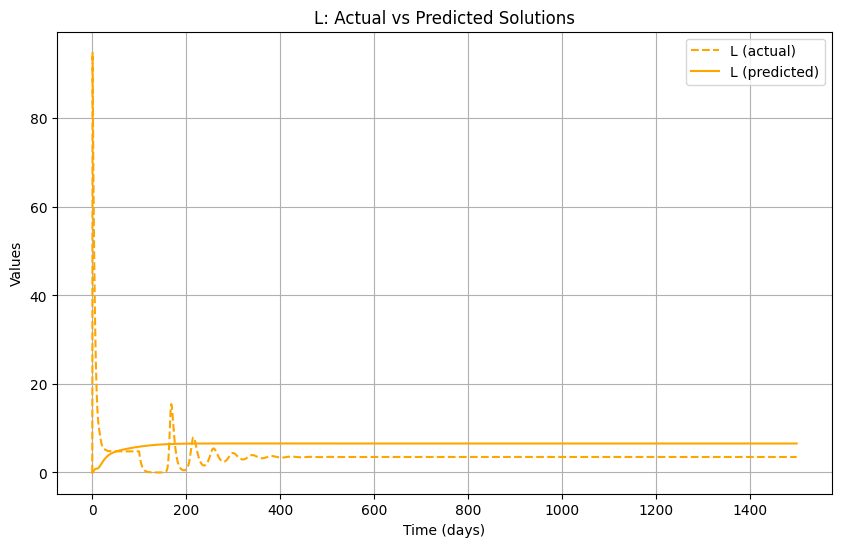

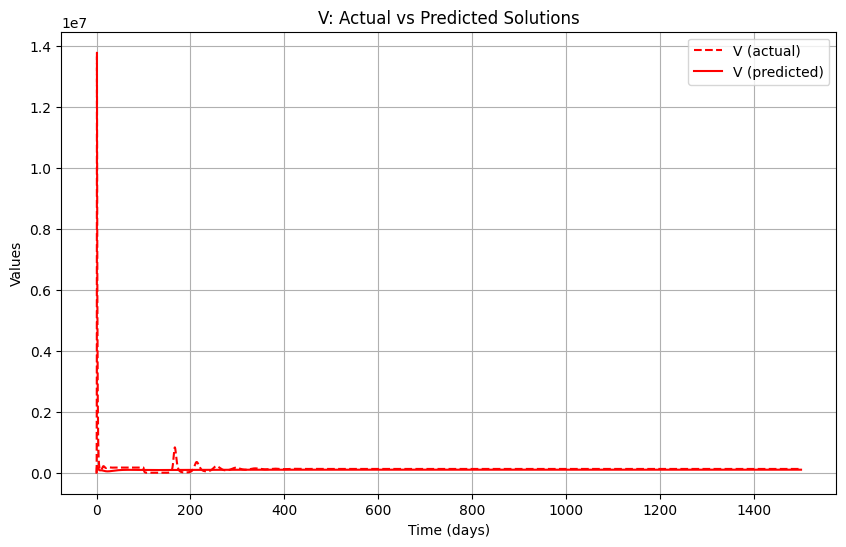

In [334]:
# Plot the numerical actual solutions compared to the predicted solutions

# Plot T (actual) vs T (predicted)
plt.figure(figsize=(10, 6))
plt.plot(t_pred, T, label='T (actual)', color='blue', linestyle='--')
plt.plot(t_pred, T_pred_denorm, label='T (predicted)', color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Values')
plt.title('T: Actual vs Predicted Solutions')
plt.legend()
plt.grid(True)
plt.show()

# Plot I (actual) vs I (predicted)
plt.figure(figsize=(10, 6))
plt.plot(t_pred, I, label='I (actual)', color='green', linestyle='--')
plt.plot(t_pred, I_pred_denorm, label='I (predicted)', color='green')
plt.xlabel('Time (days)')
plt.ylabel('Values')
plt.title('I: Actual vs Predicted Solutions')
plt.legend()
plt.grid(True)
plt.show()

# Plot L (actual) vs L (predicted)
plt.figure(figsize=(10, 6))
plt.plot(t_pred, L, label='L (actual)', color='orange', linestyle='--')
plt.plot(t_pred, L_pred_denorm, label='L (predicted)', color='orange')
plt.xlabel('Time (days)')
plt.ylabel('Values')
plt.title('L: Actual vs Predicted Solutions')
plt.legend()
plt.grid(True)
plt.show()

# Plot V (actual) vs V (predicted)
plt.figure(figsize=(10, 6))
plt.plot(t_pred, V, label='V (actual)', color='red', linestyle='--')
plt.plot(t_pred, V_pred_denorm, label='V (predicted)', color='red')
plt.xlabel('Time (days)')
plt.ylabel('Values')
plt.title('V: Actual vs Predicted Solutions')
plt.legend()
plt.grid(True)
plt.show()



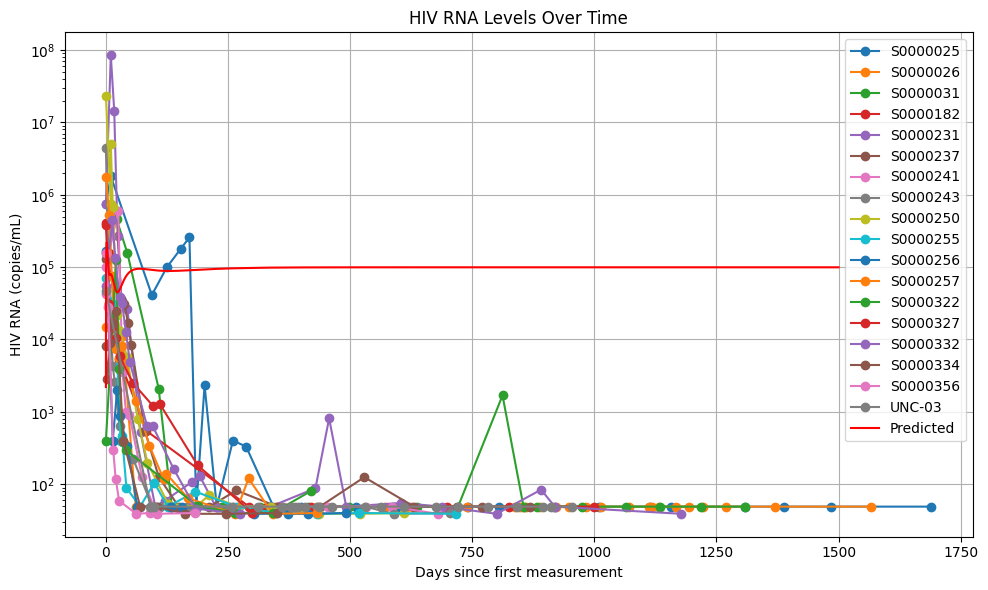

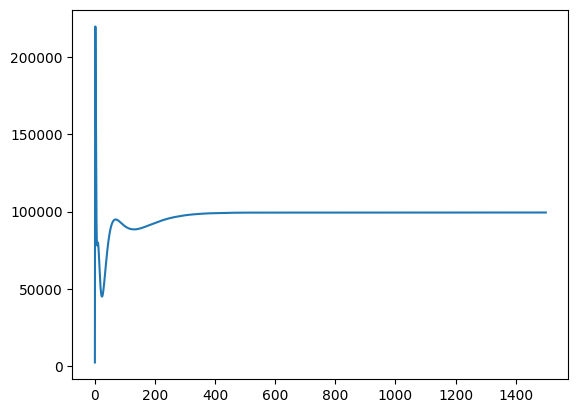

In [335]:
plt.figure(figsize=(10,6))

for uid in df['uid'].unique():
    data = df[df['uid'] == uid].sort_values('labdt')
    
    # Calculate days since first measurement for this patient
    data['days_since_start'] = (data['labdt'] - data['labdt'].min()).dt.days
    
    plt.semilogy(data['days_since_start'], data['hivrna'], 'o-', label=uid)

plt.plot(t_pred, V_pred_denorm, label='Predicted', color='red')

plt.xlabel('Days since first measurement')
plt.ylabel('HIV RNA (copies/mL)')
plt.title('HIV RNA Levels Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(t_pred, V_pred_denorm)
plt.show()


In [ ]:
#Final learned parameter values:
#d: 0.248000
#beta: 0.000021
#f: 0.000025
#a: 0.102000
#delta_I: 0.824000
#delta_L: -0.097200
#c: 22.900000
#p: 4000.000000
#lambda: 1000.000000
